In [2]:
import numpy as np
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
# 设置输出结果列对齐
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
df = pd.read_csv(r"C:\Users\邓亮\Documents\爬虫文件\广州近五年天气数据.csv")
df["日期"] = df["日期"].str.strip("广州天气预报")
df['日期'] = pd.to_datetime(df['日期'], format='%Y年%m月%d日')

df['weekday'] = pd.to_datetime(df['日期']).dt.day_name()
# df['weekday'] = df['weekday'].str.strftime('%a')

df["最高温"] = df["最高温"].str.replace('℃', '').astype(int)
df["最低温"] = df["最低温"].str.replace('℃', '').astype(int)
df = df.assign(avg_temp=(df['最高温'] + df['最低温']) / 2)

new_columns = {'日期': 'date', '天气': 'weather','最低温': 'min_temp','最高温': 'max_temp','风向风力':'wind','是否为恶劣天气':'severe'}
df = df.rename(columns=new_columns)

new_columns = ['date', 'weekday', 'min_temp','max_temp','avg_temp','weather','wind','severe']
df = df[new_columns]

df = df.drop(['weather','wind','severe'], axis=1)

df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

df = df.drop(['date'], axis=1)

new_columns = ['year', 'month', 'day','weekday','min_temp','max_temp','avg_temp']
df = df[new_columns]

df['temp_1'] = df['max_temp'].shift()  # temp_1：昨天的最高温度值

# 手动补充缺失值
df['temp_1'] = df['temp_1'].fillna(29)
df['temp_1'] = df['temp_1'].astype(int)

df['temp_2'] = df['max_temp'].shift(2)  # temp_2：前天的最高温度值

# 手动补充连续的两个缺失值，分别为不同的值
mask = df['temp_2'].isnull() & df['temp_2'].shift().isnull()
df.loc[mask, 'temp_2'] = [28, 29]
df['temp_2'] = df['temp_2'].astype(int)

new_columns = ['year', 'month', 'day','weekday','temp_2','temp_1','avg_temp','max_temp','min_temp']
df = df[new_columns]

new_columns = {'max_temp': 'actual', 'min_temp': 'guess'}
df = df.rename(columns=new_columns)

df.head(10)

,year,month,day,weekday,temp_2,temp_1,avg_temp,actual,guess
0,2018,5,1,Tuesday,28,29,27.0,30,24
1,2018,5,2,Wednesday,29,30,27.0,31,23
2,2018,5,3,Thursday,30,31,26.5,30,23
3,2018,5,4,Friday,31,30,24.5,27,22
4,2018,5,5,Saturday,30,27,27.0,30,24
5,2018,5,6,Sunday,27,30,27.0,30,24
6,2018,5,7,Monday,30,30,25.5,29,22
7,2018,5,8,Tuesday,30,29,24.0,26,22
8,2018,5,9,Wednesday,29,26,24.5,27,22
9,2018,5,10,Thursday,26,27,24.0,26,22


In [3]:
print('数据维度:', df.shape)

数据维度: (1862, 9)


In [4]:
# 统计指标
df.describe()

,year,month,day,temp_2,temp_1,avg_temp,actual,guess
count,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000,1862.000000
mean,2020.373255,6.501074,15.700859,27.473684,27.477981,23.615736,27.482277,19.749194
std,1.515031,3.423965,8.813379,6.088644,6.091837,5.939911,6.095731,6.047540
min,2018.000000,1.000000,1.000000,7.000000,7.000000,5.500000,7.000000,2.000000
25%,2019.000000,4.000000,8.000000,23.000000,23.000000,19.000000,23.000000,15.000000
50%,2020.000000,6.000000,16.000000,28.000000,28.000000,24.500000,28.000000,21.000000
75%,2022.000000,9.000000,23.000000,33.000000,33.000000,29.000000,33.000000,25.000000
max,2023.000000,12.000000,31.000000,39.000000,39.000000,33.500000,39.000000,29.000000


In [5]:
# 处理时间数据
import datetime

# 分别得到年，月，日
years = df['year']
months = df['month']
days = df['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [6]:
dates[:5]

[datetime.datetime(2018, 5, 1, 0, 0),
 datetime.datetime(2018, 5, 2, 0, 0),
 datetime.datetime(2018, 5, 3, 0, 0),
 datetime.datetime(2018, 5, 4, 0, 0),
 datetime.datetime(2018, 5, 5, 0, 0)]

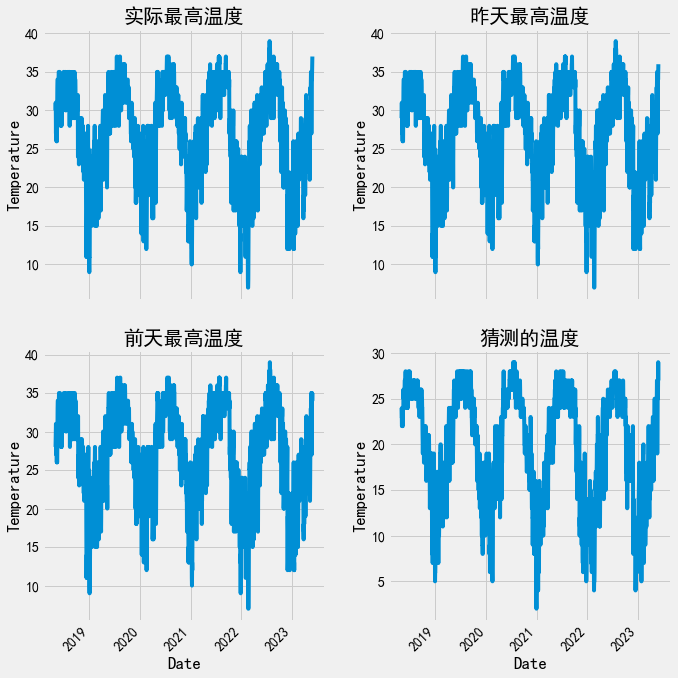

In [7]:
# 准备画图
import matplotlib.pyplot as plt

%matplotlib inline

# 指定默认风格
plt.style.use('fivethirtyeight')# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, df['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('实际最高温度')

# 昨天
ax2.plot(dates, df['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('昨天最高温度')

# 前天
ax3.plot(dates, df['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('前天最高温度')

# 猜测的温度
ax4.plot(dates, df['guess'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('猜测的温度')

plt.tight_layout(pad=2)

In [8]:
# 独热编码
df = pd.get_dummies(df)
df.head(5)

,year,month,day,temp_2,temp_1,avg_temp,actual,guess,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2018,5,1,28,29,27.0,30,24,0,0,0,0,0,1,0
1,2018,5,2,29,30,27.0,31,23,0,0,0,0,0,0,1
2,2018,5,3,30,31,26.5,30,23,0,0,0,0,1,0,0
3,2018,5,4,31,30,24.5,27,22,1,0,0,0,0,0,0
4,2018,5,5,30,27,27.0,30,24,0,0,1,0,0,0,0


In [9]:
print('Shape of df after one-hot encoding:', df.shape)

Shape of df after one-hot encoding: (1862, 15)


In [10]:
type(df)

pandas.core.frame.DataFrame

In [11]:
# 数据与标签
import numpy as np

# 标签
labels = np.array(df['actual'])

# 在特征中去掉标签
df= df.drop('actual', axis = 1)

# 名字单独保存一下，以备后患
df_list = list(df.columns)

# 转换成合适的格式
df = np.array(df)
df

array([[2.018e+03, 5.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.018e+03, 5.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.018e+03, 5.000e+00, 3.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.023e+03, 5.000e+00, 2.900e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.023e+03, 5.000e+00, 3.000e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.023e+03, 5.000e+00, 3.100e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00]])

In [13]:
# 数据集切分
from sklearn.model_selection import train_test_split

train_df, test_df, train_labels, test_labels = train_test_split(df, labels, test_size = 0.25, random_state = 42)

In [14]:
print('训练集特征:', train_df.shape)
print('训练集标签:', train_labels.shape)
print('测试集特征:', test_df.shape)
print('测试集标签:', test_labels.shape)

训练集特征: (1396, 14)
训练集标签: (1396,)
测试集特征: (466, 14)
测试集标签: (466,)


In [15]:
# 导入算法
from sklearn.ensemble import RandomForestRegressor

# 建模
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# 训练
rf.fit(train_df, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [16]:
# 预测结果
predictions = rf.predict(test_df)

# 计算误差
errors = abs(predictions - test_labels)

# mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

print ('MAPE:',np.mean(mape))

MAPE: 0.9369472985583546


In [17]:
# 导入所需工具包
from sklearn.tree import export_graphviz
import pydot #pip install pydot

# 拿到其中的一棵树
tree = rf.estimators_[5]

# 导出成dot文件
export_graphviz(tree, out_file = 'tree.dot', feature_names = df_list, rounded = True, precision = 1)

# 绘图
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# 展示
graph.write_png('tree.png'); 

In [18]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 14


In [20]:
# 限制一下树模型
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_df, train_labels)

# 提取一颗树
tree_small = rf_small.estimators_[5]

# 保存
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = df_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

In [22]:
# 得到特征重要性
importances = list(rf.feature_importances_)

# 转换格式
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(df_list, importances)]

# 排序
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# 对应进行打印
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: avg_temp             Importance: 0.97
Variable: guess                Importance: 0.02
Variable: year                 Importance: 0.0
Variable: month                Importance: 0.0
Variable: day                  Importance: 0.0
Variable: temp_2               Importance: 0.0
Variable: temp_1               Importance: 0.0
Variable: weekday_Friday       Importance: 0.0
Variable: weekday_Monday       Importance: 0.0
Variable: weekday_Saturday     Importance: 0.0
Variable: weekday_Sunday       Importance: 0.0
Variable: weekday_Thursday     Importance: 0.0
Variable: weekday_Tuesday      Importance: 0.0
Variable: weekday_Wednesday    Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:
# 选择最重要的那两个特征来试一试
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# 拿到这俩特征
important_indices = [df_list.index('temp_1'), df_list.index('avg_temp')]
train_important = train_df[:, important_indices]
test_important = test_df[:, important_indices]

# 重新训练模型
rf_most_important.fit(train_important, train_labels)

# 预测结果
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# 评估结果

mape = np.mean(100 * (errors / test_labels))

print('mape:', mape)

mape: 3.8606794068555748


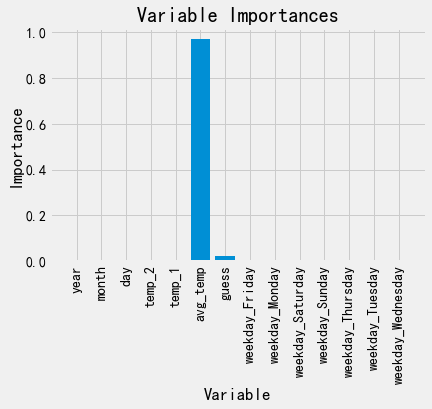

In [28]:
# 转换成list格式
x_values = list(range(len(importances)))

# 绘图
plt.bar(x_values, importances, orientation = 'vertical')

# x轴名字
plt.xticks(x_values, df_list, rotation='vertical')

# 图名
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

In [30]:
# 预测值与真实值之间的差异

# 日期数据
months = df[:, df_list.index('month')]
days = df[:, df_list.index('day')]
years = df[:, df_list.index('year')]

# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = test_df[:, df_list.index('month')]
days = test_df[:, df_list.index('day')]
years = test_df[:, df_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions}) 

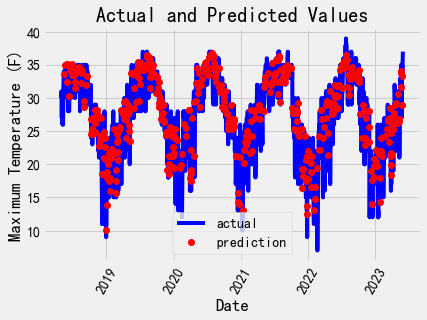

In [31]:
# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');
